In [2]:
# Google Colab integration
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install bert-score transformers timm ftfy regex
!pip install datasets accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.5 MB/s eta 0:00:00


**Imports**

In [2]:
import os
import io
import sys
import re
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from PIL import Image
from torchvision import transforms
from collections import defaultdict, OrderedDict, Counter
import warnings
warnings.filterwarnings('ignore')
from transformers import AutoTokenizer, AutoModel, AutoImageProcessor, AutoModelForZeroShotImageClassification, AutoProcessor, BertModel, BertConfig
from transformers import ViTModel, ViTConfig
from transformers import BertModel, BertConfig
from transformers import CLIPModel, CLIPProcessor, CLIPConfig
import timm
from torchvision.models import resnet50, ResNet50_Weights
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from bert_score import BERTScorer
import jieba
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
import seaborn as sns
from torch.cuda.amp import autocast, GradScaler

# Google Colab integration
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Configuration**

In [4]:
class Config:
    # Data paths
    IMAGE_BASE_PATH = '/content/drive/MyDrive/AML AA/imgs'
    CNNMODEL_SAVE_PATH = '/content/drive/MyDrive/AML AA/cnn_bilstm.pth'
    CLIPMODEL_SAVE_PATH = '/content/drive/MyDrive/AML AA/pubmedclip.pth'

    # Model parameters
    MAX_SEQ_LENGTH = 64
    IMAGE_SIZE = (224, 224)
    EMBED_DIM = 128
    HIDDEN_DIM = 256
    VOCAB_PAD_IDX = 0
    VOCAB_UNK_IDX = 1

    # Training parameters
    BATCH_SIZE = 8
    LEARNING_RATE = 1e-3
    NUM_EPOCHS = 25
    RESUME_TRAINING = False
    MINIMAL_RUN = False

    # Data augmentation
    ENABLE_AUGMENTATION = False
    AUGMENTATION_FACTOR = 3
    AUGMENTATION_P = 0.5

    # Data processing
    RANDOM_SEED = 42
    TRAIN_SPLIT = 'train'
    VAL_SPLIT = 'validation'
    TEST_SPLIT = 'test'

    # Model selection
    TEXT_MODEL_NAME = "emilyalsentzer/Bio_ClinicalBERT"
    CLIP_MODEL_NAME = "flaviagiammarino/pubmed-clip-vit-base-patch32"
    USE_PRETRAINED_VISION = True

    # Enhanced evaluation
    EVALUATE_OPEN_CLOSED = True
    EVALUATE_BERTSCORE = True
    BERTSCORE_MODEL = "bert-base-chinese"
    DETECT_LANGUAGE = True

    # Training optimization
    GRADIENT_ACCUMULATION_STEPS = 2
    GRAD_CLIP_MAX_NORM = 1.0
    USE_AMP = True  # Mixed precision training
    EARLY_STOPPING_PATIENCE = 5

config = Config()

In [5]:
def set_seed(seed=42):
    """Set all random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [6]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Clean GPU memory
if torch.cuda.is_available():
  torch.cuda.empty_cache()

# Set seeds
set_seed(config.RANDOM_SEED)

Using device: cuda


**Data Loading**: Load SLAKE dataset from Hugging Face

In [7]:
def load_slake_data():
    try:
        print("Loading SLAKE dataset...")
        dataset = load_dataset("BoKelvin/SLAKE")
        print(f"Dataset loaded successfully. Splits: {list(dataset.keys())}")

        return {
            'train': pd.DataFrame(dataset['train']),
            'validation': pd.DataFrame(dataset['validation']),
            'test': pd.DataFrame(dataset['test'])
        }
    except Exception as e:
        print(f"Error loading dataset: {e}")
        raise

data = load_slake_data()
print(f"Train: {len(data['train'])}, Validation: {len(data['validation'])}, Test: {len(data['test'])}")

Loading SLAKE dataset...


README.md:   0%|          | 0.00/568 [00:00<?, ?B/s]

train.json: 0.00B [00:00, ?B/s]

validation.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/9835 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2099 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2094 [00:00<?, ? examples/s]

Dataset loaded successfully. Splits: ['train', 'validation', 'test']
Train: 9835, Validation: 2099, Test: 2094


**Data Preprocessing**

In [8]:
def clean_text(text):
    """Clean text while preserving Chinese characters."""
    if not isinstance(text, str):
        text = str(text)
    return text.strip()

def encode_categorical(df, train_mapping=None):
    """Encode categorical variables with proper unseen answer handling."""
    type_to_id = None

    # Answer type encoding
    if 'answer_type' in df.columns:
        if train_mapping and 'type_to_id' in train_mapping:
            type_to_id = train_mapping['type_to_id']
        else:
            unique_types = sorted(df['answer_type'].unique())
            type_to_id = {t: i for i, t in enumerate(unique_types)}

        df['answer_type_id'] = df['answer_type'].map(type_to_id).fillna(-1).astype(int)
        df.attrs['type_mapping'] = {'type_to_id': type_to_id}

    # Answer encoding with proper UNK handling
    if 'answer' in df.columns:
        if train_mapping and 'answer_to_id' in train_mapping:
            answer_to_id = train_mapping['answer_to_id']
            id_to_answer = {v: k for k, v in answer_to_id.items()}
        else:
            unique_answers = sorted(df['answer'].unique())
            answer_to_id = {ans: i for i, ans in enumerate(unique_answers, start=2)}  # Start from 2 (0=PAD, 1=UNK)
            id_to_answer = {v: k for k, v in answer_to_id.items()}

        # Add special tokens
        answer_to_id['<PAD>'] = config.VOCAB_PAD_IDX
        answer_to_id['<UNK>'] = config.VOCAB_UNK_IDX
        id_to_answer[config.VOCAB_PAD_IDX] = '<PAD>'
        id_to_answer[config.VOCAB_UNK_IDX] = '<UNK>'

        # Map answers, use UNK for unseen
        df['answer_id'] = df['answer'].map(answer_to_id)
        unseen_mask = df['answer_id'].isna()

        if unseen_mask.any():
            print(f"  Found {unseen_mask.sum()} unseen answers in {df.shape[0]} samples")
            df.loc[unseen_mask, 'answer_id'] = config.VOCAB_UNK_IDX

        df['answer_id'] = df['answer_id'].astype(int)
        df.attrs['answer_mapping'] = {'answer_to_id': answer_to_id, 'id_to_answer': id_to_answer}

        if train_mapping is None:
            return df, {
                'answer_to_id': answer_to_id,
                'id_to_answer': id_to_answer,
                'type_to_id': type_to_id if 'answer_type' in df.columns else None
            }

    return df

def preprocess_data(dataframes):
    """Preprocess data with consistent encoding across splits."""
    preprocessed = {}
    train_mapping = None

    for split_name, df in dataframes.items():
        print(f"\nPreprocessing {split_name} set...")
        df_processed = df.copy()

        # Clean text
        for col in ['question', 'answer']:
            if col in df_processed.columns:
                df_processed[col] = df_processed[col].apply(clean_text)

        # Encode categorical variables
        if split_name == config.TRAIN_SPLIT:
            df_processed, train_mapping = encode_categorical(df_processed)
        else:
            if train_mapping is None:
                raise ValueError("Train mapping must be created first")
            df_processed = encode_categorical(df_processed, train_mapping)

        # Add derived features
        df_processed = add_derived_features(df_processed)

        # Filter invalid data
        mask = df_processed['answer_id'] != config.VOCAB_UNK_IDX
        if not mask.all():
            print(f"  Removed {len(df_processed) - mask.sum()} samples with UNK answers")
            df_processed = df_processed[mask]

        # Filter empty questions and answers
        df_processed = df_processed[df_processed['question'].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)]
        df_processed = df_processed[df_processed['answer'].apply(lambda x: isinstance(x, str) and len(str(x).strip()) > 0)]

        preprocessed[split_name] = df_processed
        print(f"  Processed: {len(df_processed)} samples")

    return preprocessed

def add_derived_features(df):
    """Add useful derived features."""
    # Ensure is_augmented column exists
    if 'is_augmented' not in df.columns:
        df['is_augmented'] = False

    # Question features
    if 'question' in df.columns:
        df['question_length'] = df['question'].apply(lambda x: len(str(x)))
        df['question_word_count'] = df['question'].apply(
            lambda x: len(str(x).split()) if isinstance(x, str) else 0
        )

    # Answer features
    if 'answer' in df.columns:
        df['answer_length'] = df['answer'].apply(
            lambda x: len(str(x)) if isinstance(x, str) else 0
        )

    # Binary indicators
    if 'answer' in df.columns:
        df['is_affirmative'] = df['answer'].apply(
            lambda x: 1 if str(x).lower() in ['yes', 'true', 'correct', '是', '对', '正确'] else 0
        )
        df['is_negative'] = df['answer'].apply(
            lambda x: 1 if str(x).lower() in ['no', 'false', 'wrong', '否', '不对', '错误'] else 0
        )

    return df

def update_image_paths(df, base_path):
    """Create full image paths with validation."""
    if 'img_name' in df.columns:
        df['full_img_path'] = df['img_name'].apply(
            lambda x: os.path.join(base_path, x) if pd.notna(x) else None
        )
        # Count valid paths
        valid_paths = df['full_img_path'].apply(lambda x: os.path.exists(x) if x else False).sum()
        print(f"  Found {valid_paths}/{len(df)} existing image files")

        # Remove samples without images
        df = df[df['full_img_path'].notna()]
        df = df[df['full_img_path'].apply(lambda x: os.path.exists(x) if x else False)]

    return df

def detect_language(text):
    """Detect if text is Chinese or English."""
    if not isinstance(text, str):
        return 'unknown'

    # Count Chinese characters
    chinese_chars = sum(1 for char in text if '\u4e00' <= char <= '\u9fff')
    english_chars = sum(1 for char in text if 'a' <= char.lower() <= 'z')
    total_chars = len(text.strip())

    if total_chars == 0:
        return 'unknown'

    chinese_ratio = chinese_chars / total_chars
    if chinese_ratio > 0.3:
        return 'chinese'
    else:
        return 'english'

def classify_question_type(question):
    """Classify question as open or closed-ended with improved patterns."""
    if not isinstance(question, str):
        return 'closed'

    question_lower = question.lower().strip()

    # Chinese patterns
    chinese_open_patterns = ['什么', '哪里', '何时', '为什么', '如何', '多少', '多大']
    chinese_closed_patterns = ['是', '吗', '有没有', '是否', '对不对', '能不能', '会不会', '该不该', '要不要']

    # English patterns
    english_open_patterns = ['what', 'where', 'when', 'why', 'how', 'which', 'who', 'whose']
    english_closed_patterns = ['is there', 'are there', 'does', 'do', 'is', 'are', 'can', 'could',
                              'will', 'would', 'should', 'shall', 'has', 'have', 'had', 'was', 'were']

    # Detect language
    language = detect_language(question)

    if language == 'chinese':
        if any(pattern in question for pattern in chinese_open_patterns):
            return 'open'
        if any(pattern in question for pattern in chinese_closed_patterns):
            return 'closed'
    elif language == 'english':
        if any(pattern in question_lower.split()[0:3] for pattern in english_open_patterns):
            return 'open'
        if any(pattern in question_lower.split()[0:3] for pattern in english_closed_patterns):
            return 'closed'

    return 'closed'  # Default

preprocessed = preprocess_data(data)


Preprocessing train set...
  Processed: 9834 samples

Preprocessing validation set...
  Found 19 unseen answers in 2099 samples
  Removed 19 samples with UNK answers
  Processed: 2080 samples

Preprocessing test set...
  Found 7 unseen answers in 2094 samples
  Removed 7 samples with UNK answers
  Processed: 2087 samples


**Question Augmenter**

In [9]:
class MedicalQuestionAugmenter:
    """Enhanced medical question augmenter with safe augmentation."""

    def __init__(self):
        # Question templates - only for paraphrasing, not answer generation
        self.paraphrase_templates = {
            'presence': [
                "Is there {finding} in the image?",
                "Does the image demonstrate {finding}?",
                "Can you identify {finding}?",
                "Is {finding} visible in the image?",
                "Does this show {finding}?"
            ],
            'location': [
                "What is the location of the {finding}?",
                "Where is the {finding} located?",
                "Can you locate the {finding}?"
            ]
        }

        # Medical synonyms for safe replacement
        self.medical_synonyms = {
            'nodule': ['nodular lesion', 'nodular opacity', 'small mass'],
            'mass': ['large lesion', 'tumor', 'growth'],
            'effusion': ['fluid collection', 'pleural fluid'],
            'pneumothorax': ['collapsed lung', 'air leak'],
            'cardiomegaly': ['enlarged heart', 'cardiac enlargement'],
            'atelectasis': ['lung collapse', 'consolidation'],
            'consolidation': ['infiltrate', 'pulmonary opacity'],
            'edema': ['pulmonary congestion', 'fluid in lungs']
        }

        self.location_synonyms = ['right', 'left', 'upper', 'lower', 'middle', 'apical', 'basal']

    def augment(self, original_question, original_answer, max_augment=3):
        """Generate augmented questions while preserving original answers."""
        augmented = []

        # 1. Synonym replacement (safe)
        synonym_question = self._replace_synonyms_safe(original_question)
        if synonym_question != original_question.lower():
            augmented.append((synonym_question, original_answer))

        # 2. Template-based paraphrasing (safe - keeps answer same)
        q_type = self._classify_question_type(original_question)
        if q_type in self.paraphrase_templates and len(augmented) < max_augment:
            finding = self._extract_finding(original_question)
            if finding and finding in self.medical_synonyms:
                template = random.choice(self.paraphrase_templates[q_type])
                paraphrased = template.format(finding=finding)
                # Only use if it's different from original
                if paraphrased.lower() != original_question.lower():
                    augmented.append((paraphrased, original_answer))

        # 3. Simple rephrasing
        if len(augmented) < max_augment:
            rephrased = self._simple_rephrase(original_question)
            if rephrased != original_question.lower():
                augmented.append((rephrased, original_answer))

        return augmented[:max_augment]

    def _replace_synonyms_safe(self, question):
        """Replace words with synonyms without changing meaning."""
        question_lower = question.lower()
        words = question_lower.split()

        for i, word in enumerate(words):
            for term, synonyms in self.medical_synonyms.items():
                if word == term.lower() and synonyms:
                    # Only replace with high-confidence synonyms
                    safe_synonyms = [s for s in synonyms if s.lower() != word]
                    if safe_synonyms:
                        new_word = random.choice(safe_synonyms)
                        words[i] = new_word
                        break

        return ' '.join(words)

    def _classify_question_type(self, question):
        """Classify question type for template selection."""
        question_lower = question.lower()
        if any(word in question_lower for word in ['where', 'location', 'site', 'position']):
            return 'location'
        elif any(word in question_lower for word in ['is there', 'does it show', 'present', 'visible']):
            return 'presence'
        return 'general'

    def _extract_finding(self, question):
        """Extract medical finding from question."""
        question_lower = question.lower()
        for finding in self.medical_synonyms.keys():
            if finding in question_lower:
                return finding
        return None

    def _simple_rephrase(self, question):
        """Simple rephrasing without changing meaning."""
        rephrase_rules = [
            (r'what is', 'identify'),
            (r'where is', 'locate'),
            (r'how many', 'count the number of'),
            (r'does.*show', 'can you see'),
            (r'is there', 'are there any')
        ]

        rephrased = question.lower()
        for pattern, replacement in rephrase_rules:
            if re.search(pattern, rephrased):
                rephrased = re.sub(pattern, replacement, rephrased)

        return rephrased

    def augment_dataframe(self, df, augmentation_factor=3, probability=0.5):
        """Apply safe augmentation to dataframe."""
        if not config.ENABLE_AUGMENTATION:
            df = df.copy()
            df['is_augmented'] = False
            return df

        print(f"\nApplying safe data augmentation...")
        print(f"Factor: {augmentation_factor}, Probability: {probability}")

        augmented_rows = []

        for idx, row in df.iterrows():
            # Add original sample
            original_row = row.to_dict()
            original_row['is_augmented'] = False
            augmented_rows.append(original_row)

            # Augment with probability
            if random.random() < probability:
                question = row['question']
                answer = row['answer']

                augmented_pairs = self.augment(question, answer, max_augment=augmentation_factor)

                for aug_question, aug_answer in augmented_pairs:
                    aug_row = row.copy()
                    aug_row['question'] = aug_question
                    aug_row['answer'] = aug_answer  # Same answer
                    aug_row['is_augmented'] = True
                    augmented_rows.append(aug_row)

        augmented_df = pd.DataFrame(augmented_rows)

        # Preserve metadata
        if hasattr(df, 'attrs') and 'answer_mapping' in df.attrs:
            augmented_df.attrs = df.attrs.copy()

        print(f"  Original: {len(df)} samples")
        print(f"  Augmented: {len(augmented_df)} samples")
        print(f"  Ratio: {len(augmented_df)/len(df):.2f}x")

        return augmented_df

In [10]:
# Update image paths
preprocessed_data = preprocessed.copy()
for split in preprocessed_data:
    preprocessed_data[split] = update_image_paths(
         preprocessed_data[split], config.IMAGE_BASE_PATH)

# Apply augmentation
augmenter = MedicalQuestionAugmenter()
if config.ENABLE_AUGMENTATION:
    train_df = preprocessed_data[config.TRAIN_SPLIT]
    augmented_train_df = augmenter.augment_dataframe(
          train_df,
          augmentation_factor=config.AUGMENTATION_FACTOR,
          probability=config.AUGMENTATION_P)
    preprocessed_data[config.TRAIN_SPLIT] = augmented_train_df

  Found 9834/9834 existing image files
  Found 2080/2080 existing image files
  Found 2087/2087 existing image files


**Text Processor**

In [11]:
class TextProcessor:
    """Character-level text processor for Chinese text."""

    def __init__(self, max_length=config.MAX_SEQ_LENGTH):
        self.max_length = max_length
        self.char2idx = {
            '<PAD>': config.VOCAB_PAD_IDX,
            '<UNK>': config.VOCAB_UNK_IDX
        }
        self.idx2char = {
            config.VOCAB_PAD_IDX: '<PAD>',
            config.VOCAB_UNK_IDX: '<UNK>'
        }
        self.vocab_size = 2  # Start with PAD and UNK

    def build_vocab(self, texts, min_freq=1):
        """Build vocabulary with frequency filtering."""
        char_counter = Counter()
        for text in texts:
            if isinstance(text, str):
                char_counter.update(list(text.strip()))

        # Add frequent characters
        for char, count in char_counter.items():
            if count >= min_freq:
                idx = len(self.char2idx)
                self.char2idx[char] = idx
                self.idx2char[idx] = char

        self.vocab_size = len(self.char2idx)
        print(f"Built vocabulary with {self.vocab_size} characters (min_freq={min_freq})")

    def text_to_sequence(self, text):
        """Convert text to token sequence."""
        if not isinstance(text, str):
            text = str(text)

        chars = list(text.strip())
        seq = [self.char2idx.get(char, config.VOCAB_UNK_IDX) for char in chars]

        # Pad or truncate
        if len(seq) < self.max_length:
            seq = seq + [config.VOCAB_PAD_IDX] * (self.max_length - len(seq))
        else:
            seq = seq[:self.max_length]

        return torch.tensor(seq, dtype=torch.long)

**Image Processor**

In [12]:
class ImageProcessor:
    """Enhanced image processor with efficient caching."""

    def __init__(self, target_size=config.IMAGE_SIZE, is_train=True):
        self.target_size = target_size
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        self.is_train = is_train

        # Simple transforms for validation
        if not is_train:
            self.transform = transforms.Compose([
                transforms.Resize(target_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=self.mean, std=self.std)
            ])
        else:
            # Strong augmentation for training
            self.transform = transforms.Compose([
                transforms.RandomResizedCrop(target_size, scale=(0.8, 1.0)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=10),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.ToTensor(),
                transforms.Normalize(mean=self.mean, std=self.std),
                transforms.RandomErasing(p=0.1, scale=(0.02, 0.1))
            ])

    def load_image(self, image_path):
        """Load and process image with error handling."""
        try:
            if isinstance(image_path, str) and os.path.exists(image_path):
                with Image.open(image_path) as img:
                    image = img.convert('RGB')
                return {
                    'image': self.transform(image),
                    'success': True,
                    'error': None
                }
            else:
                # Return a proper image tensor instead of zeros
                image = Image.new('RGB', self.target_size, color='gray')
                return {
                    'image': self.transform(image),
                    'success': False,
                    'error': f"File not found: {image_path}"
                }
        except Exception as e:
            image = Image.new('RGB', self.target_size, color='gray')
            return {
                'image': self.transform(image),
                'success': False,
                'error': str(e)
            }

In [13]:
text_processor = TextProcessor()
all_questions = pd.concat([preprocessed['train']['question'],
                            preprocessed['validation']['question']]).tolist()
text_processor.build_vocab(all_questions, min_freq=2)

Built vocabulary with 344 characters (min_freq=2)


**Dataset**

In [14]:
class VQADataset(Dataset):
    """VQA Dataset for CNN-LSTM model."""

    def __init__(self, dataframe, text_processor, image_processor):
        self.dataframe = dataframe.reset_index(drop=True)
        self.text_processor = text_processor
        self.image_processor = image_processor

        # Pre-tokenize questions for efficiency
        self.questions = self.dataframe['question'].tolist()
        self.preprocessed_questions = [
            self.text_processor.text_to_sequence(q) for q in self.questions
        ]

        # Get answer mapping
        if 'answer_mapping' in self.dataframe.attrs:
            self.answer_to_id = self.dataframe.attrs['answer_mapping']['answer_to_id']
            self.id_to_answer = self.dataframe.attrs['answer_mapping']['id_to_answer']
        else:
            raise ValueError("Dataset must have answer_mapping in attrs")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Get preprocessed question
        input_ids = self.preprocessed_questions[idx]

        # Get image
        img_path = row['full_img_path'] if 'full_img_path' in row else None
        if img_path and os.path.exists(img_path):
            img_result = self.image_processor.load_image(img_path)
            pixel_values = img_result['image']
            if not img_result['success']:
                print(f"Warning: Failed to load image {img_path}")
        else:
            # Create blank image
            image = Image.new('RGB', self.image_processor.target_size, color='gray')
            pixel_values = self.image_processor.transform(image)

        # Get label
        answer = row['answer']
        label = self.answer_to_id.get(answer, config.VOCAB_UNK_IDX)
        label = torch.tensor(label, dtype=torch.long)

        return {
            'pixel_values': pixel_values,
            'input_ids': input_ids,
            'labels': label,
            'question': row['question'],
            'answer': answer,
            'img_path': img_path,
            'is_augmented': row.get('is_augmented', False)
        }

In [15]:
train_dataset = VQADataset(
    preprocessed_data['train'],
    text_processor,
    ImageProcessor(is_train=True)
)

val_dataset = VQADataset(
    preprocessed_data['validation'],
    text_processor,
    ImageProcessor(is_train=False)
)

test_dataset = VQADataset(
    preprocessed_data['test'],
    text_processor,
    ImageProcessor(is_train=False)
)

In [16]:
class VQADatasetForCLIP(Dataset):

    def __init__(self, dataframe, image_processor, clip_processor):
        self.dataframe = dataframe.reset_index(drop=True)
        self.image_processor = image_processor
        self.clip_processor = clip_processor

        self.questions = self.dataframe['question'].tolist()

        self.image_paths = []
        for idx in range(len(self.dataframe)):
            row = self.dataframe.iloc[idx]
            img_path = row['full_img_path'] if 'full_img_path' in row else None
            self.image_paths.append(img_path)

        if 'answer_mapping' in self.dataframe.attrs:
            self.answer_to_id = self.dataframe.attrs['answer_mapping']['answer_to_id']
            self.id_to_answer = self.dataframe.attrs['answer_mapping']['id_to_answer']
        else:
            raise ValueError("Dataset must have answer_mapping in attrs")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        img_path = self.image_paths[idx]

        # Load image with PIL format
        if img_path and os.path.exists(img_path):
            try:
                with open(img_path, 'rb') as f:
                    image_data = f.read()
                pil_image = Image.open(io.BytesIO(image_data)).convert('RGB')
            except Exception as e:
                print(f"Warning: Failed to load image {img_path}: {e}")
                pil_image = Image.new('RGB', config.IMAGE_SIZE, color='white')
        else:
            pil_image = Image.new('RGB', config.IMAGE_SIZE, color='white')

        # Initial Question
        question = str(row['question'])

        # Label
        answer = row['answer']
        label = self.answer_to_id.get(answer, config.VOCAB_UNK_IDX)
        label = torch.tensor(label, dtype=torch.long)

        return {
            'pil_image': pil_image,
            'question_text': question,
            'labels': label,
            'question': question,
            'answer': answer,
            'img_path': img_path,
            'is_augmented': row.get('is_augmented', False)
        }

    @staticmethod
    def clip_collate_fn(batch):
        return {
            'pil_image': [item['pil_image'] for item in batch],
            'question_text': [item['question_text'] for item in batch],
            'labels': torch.stack([item['labels'] for item in batch]),
            'question': [item['question'] for item in batch],
            'answer': [item['answer'] for item in batch],
            'img_path': [item['img_path'] for item in batch],
            'is_augmented': [item.get('is_augmented', False) for item in batch]
        }

In [17]:
clip_processor = AutoProcessor.from_pretrained(config.CLIP_MODEL_NAME)

train_clip_dataset = VQADatasetForCLIP(
    preprocessed_data['train'],
    ImageProcessor(is_train=True),
    clip_processor
)

val_clip_dataset = VQADatasetForCLIP(
    preprocessed_data['validation'],
    ImageProcessor(is_train=False),
    clip_processor
)

test_clip_dataset = VQADatasetForCLIP(
    preprocessed_data['test'],
    ImageProcessor(is_train=False),
    clip_processor
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

train_clip_loader = DataLoader(
    train_clip_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    collate_fn=VQADatasetForCLIP.clip_collate_fn,
    num_workers=2
)

val_clip_loader = DataLoader(
    val_clip_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    collate_fn=VQADatasetForCLIP.clip_collate_fn,
    num_workers=2
)

test_clip_loader = DataLoader(
    test_clip_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    collate_fn=VQADatasetForCLIP.clip_collate_fn,
    num_workers=2
)

print(f"CNN-LSTM Train: {len(train_loader.dataset)} samples")
print(f"CNN-LSTM Val: {len(val_loader.dataset)} samples")
print(f"CNN-LSTM Test: {len(test_loader.dataset)} samples")
print(f"PubMedCLIP Train: {len(train_clip_loader.dataset)} samples")
print(f"PubMedCLIP Val: {len(val_clip_loader.dataset)} samples")
print(f"PubMedCLIP Test: {len(test_clip_loader.dataset)} samples")

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CNN-LSTM Train: 9834 samples
CNN-LSTM Val: 2080 samples
CNN-LSTM Test: 2087 samples
PubMedCLIP Train: 9834 samples
PubMedCLIP Val: 2080 samples
PubMedCLIP Test: 2087 samples


**CNN-BiLSTM Model**

In [18]:
class CNN_BILSTM_VQA(nn.Module):

    def __init__(self, vocab_size, num_answers, embed_dim=128, hidden_dim=256, dropout=0.3):
        super().__init__()

        # Text encoder
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=config.VOCAB_PAD_IDX)
        self.lstm = nn.LSTM(embed_dim, hidden_dim,
                            batch_first=True,
                            bidirectional=True,
                            num_layers=2,
                            dropout=dropout if dropout > 0 else 0)

        # Image encoder using pre-trained ResNet
        self.cnn = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.cnn  .fc = nn.Identity()  # Remove classification head
        cnn_out_size = 2048  # ResNet50 feature dimension

        # Fusion layers
        lstm_out_size = hidden_dim * 2  # bidirectional
        fusion_input_size = cnn_out_size + lstm_out_size

        self.fusion = nn.Sequential(nn.Linear(fusion_input_size, 512),
                                    nn.BatchNorm1d(512),
                                    nn.ReLU(),
                                    nn.Dropout(dropout),
                                    nn.Linear(512, 256),
                                    nn.BatchNorm1d(256),
                                    nn.ReLU(),
                                    nn.Dropout(dropout),
                                    nn.Linear(256, num_answers))

        self.dropout = nn.Dropout(dropout)

    def forward(self, images, questions):
        # Process images
        img_features = self.cnn(images)
        img_features = self.dropout(img_features)

        # Process text
        embedded = self.embedding(questions)
        lstm_out, (hidden, _) = self.lstm(embedded)

        # Use mean pooling of BiLSTM outputs
        text_features = lstm_out.mean(dim=1)
        text_features = self.dropout(text_features)

        # Fuse features
        combined = torch.cat([img_features, text_features], dim=1)
        logits = self.fusion(combined)

        return logits

In [19]:
train_mapping = preprocessed_data['train'].attrs.get('answer_mapping', {})
if 'id_to_answer' in train_mapping:
    num_answers = len(train_mapping['id_to_answer'])
else:
    num_answers = len(preprocessed_data['train']['answer'].unique()) + 2  # +2 for PAD and UNK

cnn_bilstm_model = CNN_BILSTM_VQA(
    vocab_size=text_processor.vocab_size,
    num_answers=num_answers
)
cnn_bilstm_model.to(device)
print(f"CNN-BiLSTM Model created with {num_answers} answer classes")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]


CNN-BiLSTM Model created with 486 answer classes


**PubMedBLIP Model**

In [20]:
class PubMedCLIP_VQA(nn.Module):

    def __init__(self, num_answers, dropout=0.3, temperature=1.0):
        super().__init__()

        # Load PubMedCLIP
        self.clip_model = CLIPModel.from_pretrained(config.CLIP_MODEL_NAME)
        self.processor = CLIPProcessor.from_pretrained(config.CLIP_MODEL_NAME)

        # Get dimensions
        self.projection_dim = self.clip_model.config.projection_dim  # 512

        # Fusion with attention
        self.fusion = self._build_fusion_network(num_answers, dropout)

        # Smart fine-tuning strategy - setup AFTER fusion is built
        self._setup_fine_tuning()

        print(f"PubMedCLIP loaded successfully")
        print(f"Projection dimension: {self.projection_dim}")

    def _setup_fine_tuning(self):
        # Initially freeze everything
        for param in self.clip_model.parameters():
            param.requires_grad = False

        # Unfreeze last transformer blocks
        layers_to_unfreeze = [
            # Vision encoder last layers
            'vision_model.encoder.layers.10',
            'vision_model.encoder.layers.11',
            'vision_model.post_layernorm',
            # Text encoder last layers
            'text_model.encoder.layer.10',
            'text_model.encoder.layer.11',
            'text_model.pooler.dense',
        ]

        for name, param in self.clip_model.named_parameters():
            if any(layer in name for layer in layers_to_unfreeze):
                param.requires_grad = True

        # Always train fusion layers
        for param in self.fusion.parameters():
            param.requires_grad = True

    def _build_fusion_network(self, num_answers, dropout):
        return nn.Sequential(
            # Layer 1: Project concatenated features
            nn.Linear(self.projection_dim * 2, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            nn.Dropout(dropout),

            # Layer 2: Cross-modal interaction
            nn.Linear(1024, 768),
            nn.BatchNorm1d(768),
            nn.GELU(),
            nn.Dropout(dropout * 0.8),

            # Layer 3: High-level features
            nn.Linear(768, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(dropout * 0.6),

            # Layer 4: Classification head
            nn.Linear(512, num_answers)
        )

    def forward(self, images, questions):
        inputs = self.processor(
            text=questions,
            images=images,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=77,  # CLIP's max length
            return_attention_mask=True
        ).to(self.device)

        # Forward pass
        with torch.set_grad_enabled(self.training):
            outputs = self.clip_model(**inputs)

        # Get multimodal embeddings
        image_embeds = outputs.image_embeds
        text_embeds = outputs.text_embeds

        # Concatenate and classify
        combined = torch.cat([image_embeds, text_embeds], dim=-1)
        logits = self.fusion(combined)

        return logits

    @property
    def device(self):
        return next(self.parameters()).device

In [22]:
clip_model = PubMedCLIP_VQA(num_answers=486)
clip_model.to(device)
print(f"PubMedCLIP Model created with {num_answers} answer classes")

PubMedCLIP loaded successfully
Projection dimension: 512
PubMedCLIP Model created with 486 answer classes


**Checkpoint**

In [23]:
def save_checkpoint(model, optimizer, epoch, val_acc, filepath, model_type="cnn_bilstm"):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_accuracy': val_acc,
        'model_type': model_type
    }, filepath)
    print(f"Saved checkpoint: {filepath} (Val Acc: {val_acc:.2f}%)")

def load_checkpoint(filepath, model, optimizer=None, device=device):
    """Load model checkpoint."""
    checkpoint = torch.load(filepath, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    print(f"Loaded checkpoint: {filepath}")
    print(f"Epoch: {checkpoint.get('epoch', 'N/A')}")
    print(f"Val Accuracy: {checkpoint.get('val_accuracy', 'N/A'):.2f}%")

    return checkpoint.get('epoch', 0), checkpoint.get('val_accuracy', 0)

**Training**

In [24]:
def train_epoch_amp(model, dataloader, criterion, optimizer, scheduler, device, model_type="cnn_bilstm"):
    """Train with mixed precision support."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    scaler = GradScaler(enabled=config.USE_AMP)
    accumulation_steps = config.GRADIENT_ACCUMULATION_STEPS
    optimizer.zero_grad()

    for batch_idx, batch in enumerate(dataloader):
        # Prepare batch based on model type
        if model_type == "clip":
            images = batch['pil_image']
            questions = batch['question_text']
        else:
            images = batch['pixel_values'].to(device)
            questions = batch['input_ids'].to(device)

        labels = batch['labels'].to(device)

        # Mixed precision forward pass
        with autocast(enabled=config.USE_AMP):
            if model_type == "clip":
                logits = model(images, questions)
            else:
                logits = model(images, questions)
            loss = criterion(logits, labels) / accumulation_steps

        # Backward pass with scaling
        scaler.scale(loss).backward()

        total_loss += loss.item() * accumulation_steps
        predictions = logits.argmax(dim=-1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

        # Gradient accumulation step
        if (batch_idx + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                max_norm=config.GRAD_CLIP_MAX_NORM
            )
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()

        # Progress monitoring
        if (batch_idx + 1) % (accumulation_steps * 10) == 0:
            acc = 100 * correct / total if total > 0 else 0
            avg_loss = total_loss / (batch_idx + 1)
            print(f"  Batch {batch_idx+1}/{len(dataloader)}, Loss: {avg_loss:.4f}, Acc: {acc:.2f}%")

    # Handle remaining gradients
    if len(dataloader) % accumulation_steps != 0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=config.GRAD_CLIP_MAX_NORM)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total if total > 0 else 0

    return avg_loss, accuracy

def validate_model(model, dataloader, criterion, device, model_type="cnn_bilstm"):
    """Validate model."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            if model_type == "clip":
                images = batch['pil_image']
                questions = batch['question_text']
                logits = model(images, questions)
            else:
                images = batch['pixel_values'].to(device)
                questions = batch['input_ids'].to(device)
                logits = model(images, questions)

            labels = batch['labels'].to(device)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            predictions = logits.argmax(dim=-1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total if total > 0 else 0

    return avg_loss, accuracy

In [26]:
cnn_bilstm_optimizer = optim.Adam(cnn_bilstm_model.parameters(), lr=config.LEARNING_RATE)
cnn_bilstm_scheduler = optim.lr_scheduler.CosineAnnealingLR(cnn_bilstm_optimizer, T_max=config.NUM_EPOCHS)
cnn_bilstm_criterion = nn.CrossEntropyLoss()

# Training history storage
cnn_bilstm_history = {'train_loss': [],
                      'train_acc': [],
                      'val_loss': [],
                      'val_acc': [],
                      'lr': []}

best_cnn_bilstm_val_acc = 0

for epoch in range(config.NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{config.NUM_EPOCHS}")

    # Train
    train_loss, train_acc = train_epoch_amp(
        cnn_bilstm_model, train_loader, cnn_bilstm_criterion,
        cnn_bilstm_optimizer, None, device, model_type="cnn_bilstm"
    )

    # Validate
    val_loss, val_acc = validate_model(
        cnn_bilstm_model, val_loader, cnn_bilstm_criterion, device, model_type="cnn_bilstm"
    )

    # Update scheduler
    cnn_bilstm_scheduler.step()

    # Store history
    cnn_bilstm_history['train_loss'].append(train_loss)
    cnn_bilstm_history['train_acc'].append(train_acc)
    cnn_bilstm_history['val_loss'].append(val_loss)
    cnn_bilstm_history['val_acc'].append(val_acc)
    cnn_bilstm_history['lr'].append(cnn_bilstm_optimizer.param_groups[0]['lr'])

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_cnn_bilstm_val_acc:
        best_cnn_bilstm_val_acc = val_acc
        save_checkpoint(cnn_bilstm_model, cnn_bilstm_optimizer, epoch, val_acc,
                        config.CNNMODEL_SAVE_PATH, model_type="cnn_bilstm")
        print(f"Saved best CNN-BiLSTM model with validation accuracy: {val_acc:.2f}%")


Epoch 1/25
  Batch 20/1230, Loss: 6.2552, Acc: 0.00%
  Batch 40/1230, Loss: 5.9842, Acc: 4.38%
  Batch 60/1230, Loss: 5.7262, Acc: 5.21%
  Batch 80/1230, Loss: 5.4546, Acc: 7.19%
  Batch 100/1230, Loss: 5.2925, Acc: 7.75%
  Batch 120/1230, Loss: 5.1278, Acc: 8.65%
  Batch 140/1230, Loss: 5.0211, Acc: 8.84%
  Batch 160/1230, Loss: 4.9440, Acc: 9.53%
  Batch 180/1230, Loss: 4.9110, Acc: 9.86%
  Batch 200/1230, Loss: 4.8505, Acc: 10.44%
  Batch 220/1230, Loss: 4.8279, Acc: 10.40%
  Batch 240/1230, Loss: 4.7765, Acc: 10.42%
  Batch 260/1230, Loss: 4.7232, Acc: 10.43%
  Batch 280/1230, Loss: 4.7243, Acc: 10.49%
  Batch 300/1230, Loss: 4.6935, Acc: 10.50%
  Batch 320/1230, Loss: 4.6772, Acc: 10.82%
  Batch 340/1230, Loss: 4.6358, Acc: 11.32%
  Batch 360/1230, Loss: 4.6145, Acc: 11.28%
  Batch 380/1230, Loss: 4.5626, Acc: 11.68%
  Batch 400/1230, Loss: 4.5105, Acc: 12.00%
  Batch 420/1230, Loss: 4.4667, Acc: 12.35%
  Batch 440/1230, Loss: 4.4363, Acc: 12.53%
  Batch 460/1230, Loss: 4.4092, A

In [25]:
# Initialize PubMedCLIP
clip_optimizer = optim.Adam(clip_model.parameters(), lr=config.LEARNING_RATE)
clip_scheduler = optim.lr_scheduler.CosineAnnealingLR(clip_optimizer, T_max=config.NUM_EPOCHS)
clip_criterion = nn.CrossEntropyLoss()

# Training history storage
clip_history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

best_clip_val_acc = 0

for epoch in range(config.NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{config.NUM_EPOCHS}")

    # Train
    train_loss, train_acc = train_epoch_amp(
        clip_model, train_clip_loader, clip_criterion,
        clip_optimizer, None, device, model_type="clip"
    )

    # Validate
    val_loss, val_acc = validate_model(
        clip_model, val_clip_loader, clip_criterion, device, model_type="clip"
    )

    # Update scheduler
    clip_scheduler.step()

    # Store history
    clip_history['train_loss'].append(train_loss)
    clip_history['train_acc'].append(train_acc)
    clip_history['val_loss'].append(val_loss)
    clip_history['val_acc'].append(val_acc)
    clip_history['lr'].append(clip_optimizer.param_groups[0]['lr'])

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_clip_val_acc:
        best_clip_val_acc = val_acc
        save_checkpoint(clip_model, clip_optimizer, epoch, val_acc,
                        config.CLIPMODEL_SAVE_PATH, model_type="clip")
        print(f"Saved best PubMedCLIP model with validation accuracy: {val_acc:.2f}%")


Epoch 1/25
  Batch 20/1230, Loss: 5.7103, Acc: 10.00%
  Batch 40/1230, Loss: 5.1260, Acc: 16.25%
  Batch 60/1230, Loss: 5.0428, Acc: 15.42%
  Batch 80/1230, Loss: 4.8281, Acc: 16.72%
  Batch 100/1230, Loss: 4.6184, Acc: 18.12%
  Batch 120/1230, Loss: 4.5547, Acc: 18.23%
  Batch 140/1230, Loss: 4.3987, Acc: 20.09%
  Batch 160/1230, Loss: 4.3042, Acc: 20.47%
  Batch 180/1230, Loss: 4.2169, Acc: 20.62%
  Batch 200/1230, Loss: 4.1453, Acc: 21.25%
  Batch 220/1230, Loss: 4.0942, Acc: 21.93%
  Batch 240/1230, Loss: 4.0329, Acc: 22.55%
  Batch 260/1230, Loss: 3.9930, Acc: 23.51%
  Batch 280/1230, Loss: 3.9575, Acc: 23.93%
  Batch 300/1230, Loss: 3.9013, Acc: 24.83%
  Batch 320/1230, Loss: 3.8581, Acc: 25.12%
  Batch 340/1230, Loss: 3.8071, Acc: 25.70%
  Batch 360/1230, Loss: 3.7683, Acc: 26.04%
  Batch 380/1230, Loss: 3.7461, Acc: 26.22%
  Batch 400/1230, Loss: 3.7023, Acc: 26.66%
  Batch 420/1230, Loss: 3.6635, Acc: 26.96%
  Batch 440/1230, Loss: 3.6316, Acc: 27.33%
  Batch 460/1230, Loss: 

**Evaluation**

In [29]:
def evaluate_bertscore_batched(predictions, references, batch_size=32, model_name="bert-base-chinese"):
    """BERTScore evaluation with batching for memory efficiency."""
    try:
        scorer = BERTScorer(model_type=model_name, lang="zh")
    except Exception as e:
        print(f"Warning: Could not load {model_name}, using bert-base-multilingual-cased: {e}")
        try:
            scorer = BERTScorer(model_type="bert-base-multilingual-cased", lang="zh")
        except:
            print("Warning: BERTScore not available, returning zeros")
            return np.zeros(len(predictions)), np.zeros(len(predictions)), np.zeros(len(predictions))

    all_P, all_R, all_F1 = [], [], []

    for i in range(0, len(predictions), batch_size):
        batch_preds = predictions[i:i+batch_size]
        batch_refs = references[i:i+batch_size]

        P, R, F1 = scorer.score(batch_preds, batch_refs)
        all_P.extend(P.numpy())
        all_R.extend(R.numpy())
        all_F1.extend(F1.numpy())

    return np.array(all_P), np.array(all_R), np.array(all_F1)

def enhanced_evaluation(model, dataloader, id_to_answer, device, model_name="Model"):
    """Comprehensive evaluation with detailed metrics."""
    model.eval()
    results = []

    with torch.no_grad():
        for batch in dataloader:
            actual_questions = batch.get('question', None)

            if actual_questions is None:
                # Try alternative key names
                if 'question_text' in batch:
                    actual_questions = batch['question_text']
                elif 'questions' in batch:
                    actual_questions = batch['questions']

            # Forward pass
            if "BioMedCLIP" in model_name or "clip" in model_name.lower():
                images = batch['pil_image']
                device = next(model.parameters()).device
                try:
                    logits = model(images, actual_questions if actual_questions else batch['question_text'])
                except Exception as e:
                    print(f"Warning in forward pass: {e}")
                    # Create dummy logits
                    logits = torch.randn(len(images), len(id_to_answer)).to(device)
            else:
                images = batch['pixel_values'].to(device)
                questions_tensor = batch['input_ids'].to(device)
                logits = model(images, questions_tensor)

            labels = batch['labels'].to(device)
            predictions = logits.argmax(dim=-1)

            # Collect results
            for i in range(len(predictions)):
                pred_idx = predictions[i].item()
                gt_idx = labels[i].item()

                pred_answer = id_to_answer.get(pred_idx, "UNKNOWN")
                gt_answer = id_to_answer.get(gt_idx, "UNKNOWN")

                # Handle different batch structures
                if actual_questions is not None:
                    question = actual_questions[i]
                else:
                    question = f"Question_{i}"

                results.append({
                    'question': question,
                    'predicted': pred_answer,
                    'ground_truth': gt_answer,
                    'correct': int(pred_answer == gt_answer),
                    'question_language': detect_language(question),
                    'question_type': classify_question_type(question),
                    'is_augmented': batch.get('is_augmented', [False] * len(predictions))[i]
                })

    df_results = pd.DataFrame(results)
    display(df_results)  # renders a nice table


    if len(df_results) == 0:
        return df_results, 0, {}, {}

    # Calculate metrics
    overall_accuracy = 100 * df_results['correct'].mean()
    analysis = {}

    # By question type
    if 'question_type' in df_results.columns:
        for q_type in ['open', 'closed']:
            mask = df_results['question_type'] == q_type
            if mask.any():
                analysis[f'{q_type}_accuracy'] = 100 * df_results[mask]['correct'].mean()
                analysis[f'{q_type}_count'] = mask.sum()

    # By language
    if 'question_language' in df_results.columns:
        for lang in ['chinese', 'english']:
            mask = df_results['question_language'] == lang
            if mask.any():
                analysis[f'{lang}_accuracy'] = 100 * df_results[mask]['correct'].mean()
                analysis[f'{lang}_count'] = mask.sum()

    # BERTScore for open-ended questions
    bertscore_results = {}
    if config.EVALUATE_BERTSCORE:
        open_mask = df_results['question_type'] == 'open'
        if open_mask.any():
            open_df = df_results[open_mask]
            predictions_list = open_df['predicted'].astype(str).tolist()
            references_list = open_df['ground_truth'].astype(str).tolist()

            P, R, F1 = evaluate_bertscore_batched(predictions_list, references_list)
            open_df.loc[:, 'bertscore_f1'] = F1

            bertscore_results = {'mean_precision': P.mean(),
                                 'mean_recall': R.mean(),
                                 'mean_f1': F1.mean(),
                                 'std_f1': F1.std(),
                                 'num_samples': len(open_df)}

    return df_results, overall_accuracy, analysis, bertscore_results

In [30]:
# Get answer mappings
id_to_answer = preprocessed_data['train'].attrs['answer_mapping']['id_to_answer']

# Evaluate CNN-LSTM
print("\nEvaluating CNN-BiLSTM model...")
best_cnn_path = config.CNNMODEL_SAVE_PATH
best_cnn_epoch, best_cnn_val_acc = load_checkpoint(best_cnn_path, cnn_bilstm_model, None, device)
cnn_bilstm_results, cnn_bilstm_acc, cnn_bilstm_analysis, cnn_bilstm_bertscore = enhanced_evaluation(
    cnn_bilstm_model, test_loader, id_to_answer, device, model_name="CNN-BiLSTM"
)

# Evaluate PubMedCLIP
print("\nEvaluating PubMedCLIP model...")
best_clip_path = config.CLIPMODEL_SAVE_PATH
best_clip_epoch, best_clip_val_acc = load_checkpoint(best_clip_path, clip_model, None, device)
clip_results, clip_acc, clip_analysis, clip_bertscore = enhanced_evaluation(
    clip_model, test_clip_loader, id_to_answer, device, model_name="PubMedCLIP"
)

# Count trainable parameters
cnn_params = sum(p.numel() for p in cnn_bilstm_model.parameters() if p.requires_grad)
clip_params = sum(p.numel() for p in clip_model.parameters() if p.requires_grad)

print(f"\nCNN-BiLSTM Parameters: {cnn_params:,}")
print(f"PubMedCLIP Parameters: {clip_params:,}")


Evaluating CNN-BiLSTM model...
Loaded checkpoint: /content/drive/MyDrive/AML AA/cnn_bilstm.pth
Epoch: 24
Val Accuracy: 71.11%


,question,predicted,ground_truth,correct,question_language,question_type,is_augmented
0,What modality is used to take this image?,CT,CT,1,english,open,tensor(False)
1,Which part of the body does this image belong to?,Chest,Chest,1,english,open,tensor(False)
2,What is the largest organ in the picture?,Lung,Lung,1,english,open,tensor(False)
3,Does the picture contain liver?,Yes,No,0,english,closed,tensor(False)
4,Does the picture contain lung?,Yes,Yes,1,english,closed,tensor(False)
...,...,...,...,...,...,...,...
2082,图片中包含肝脏吗?,不包含,包含,0,chinese,closed,tensor(False)
2083,图片中包含肺吗?,包含,包含,1,chinese,closed,tensor(False)
2084,图片中包含心脏吗?,不包含,不包含,1,chinese,closed,tensor(False)
2085,肺是异常的吗?,是的,不是,0,chinese,closed,tensor(False)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]


Evaluating PubMedCLIP model...
Loaded checkpoint: /content/drive/MyDrive/AML AA/pubmedclip.pth
Epoch: 24
Val Accuracy: 78.65%


,question,predicted,ground_truth,correct,question_language,question_type,is_augmented
0,What modality is used to take this image?,CT,CT,1,english,open,False
1,Which part of the body does this image belong to?,Chest,Chest,1,english,open,False
2,What is the largest organ in the picture?,Lung,Lung,1,english,open,False
3,Does the picture contain liver?,No,No,1,english,closed,False
4,Does the picture contain lung?,Yes,Yes,1,english,closed,False
...,...,...,...,...,...,...,...
2082,图片中包含肝脏吗?,包含,包含,1,chinese,closed,False
2083,图片中包含肺吗?,包含,包含,1,chinese,closed,False
2084,图片中包含心脏吗?,包含,不包含,0,chinese,closed,False
2085,肺是异常的吗?,不是,不是,1,chinese,closed,False



CNN-BiLSTM Parameters: 27,488,550
PubMedCLIP Parameters: 16,661,734


**Visualization**

In [45]:
class Visualization:
    """Class for comprehensive visualization of VQA model comparisons."""
    def __init__(self, use_chinese_font=True):
        if use_chinese_font:
            self.setup_chinese_font()

    @staticmethod
    def setup_chinese_font():

        try:
            # Try to use Chinese font if available
            matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
            matplotlib.rcParams['axes.unicode_minus'] = False

            if os.path.exists('/content'):
                # Download a Chinese font
                !wget -q -O /tmp/SimHei.ttf https://github.com/StellarCN/scp_zh/raw/master/fonts/SimHei.ttf

                # Add to matplotlib font manager
                import matplotlib.font_manager as fm
                fm.fontManager.addfont("/tmp/SimHei.ttf")
                font_name = fm.FontProperties(fname="/tmp/SimHei.ttf").get_name()
                matplotlib.rcParams['font.sans-serif'] = [font_name]
                matplotlib.rcParams['axes.unicode_minus'] = False

                print(f"Chinese font set to: {font_name}")
        except Exception as e:
            print(f"Could not setup Chinese font: {e}")
            # Fallback to default fonts
            matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
            matplotlib.rcParams['axes.unicode_minus'] = False

    @staticmethod
    def plot_training_history(cnn_bilstm_history, clip_history, save_path=None):
        """Plot training and validation curves for both models."""
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        epochs = range(1, len(cnn_bilstm_history['train_loss']) + 1)

        # Plot loss curves
        axes[0, 0].plot(epochs, cnn_bilstm_history['train_loss'], 'b-', label='CNN-BiLSTM Train', linewidth=2)
        axes[0, 0].plot(epochs, cnn_bilstm_history['val_loss'], 'b--', label='CNN-BiLSTM Val', linewidth=2)
        axes[0, 0].plot(epochs, clip_history['train_loss'], 'r-', label='PubMedCLIP Train', linewidth=2)
        axes[0, 0].plot(epochs, clip_history['val_loss'], 'r--', label='PubMedCLIP Val', linewidth=2)
        axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Plot accuracy curves
        axes[0, 1].plot(epochs, cnn_bilstm_history['train_acc'], 'b-', label='CNN-BiLSTM Train', linewidth=2)
        axes[0, 1].plot(epochs, cnn_bilstm_history['val_acc'], 'b--', label='CNN-BiLSTM Val', linewidth=2)
        axes[0, 1].plot(epochs, clip_history['train_acc'], 'r-', label='PubMedCLIP Train', linewidth=2)
        axes[0, 1].plot(epochs, clip_history['val_acc'], 'r--', label='PubMedCLIP Val', linewidth=2)
        axes[0, 1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy (%)')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Plot learning rate (if available)
        axes[1, 0].plot(epochs, cnn_bilstm_history.get('lr', [0]*len(epochs)), 'b-',
                        label='CNN-BiLSTM LR', linewidth=2)
        axes[1, 0].plot(epochs, clip_history.get('lr', [0]*len(epochs)), 'r-',
                        label='PubMedCLIP LR', linewidth=2)
        axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].set_yscale('log')

        # Plot accuracy difference
        acc_diff = np.array(cnn_bilstm_history['val_acc']) - np.array(clip_history['val_acc'])
        axes[1, 1].plot(epochs, acc_diff, 'g-', linewidth=2)
        axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
        axes[1, 1].fill_between(epochs, 0, acc_diff, where=acc_diff > 0,
                               color='blue', alpha=0.3, label='CNN-BiLSTM Better')
        axes[1, 1].fill_between(epochs, 0, acc_diff, where=acc_diff < 0,
                               color='red', alpha=0.3, label='PubMedCLIP Better')
        axes[1, 1].set_title('Validation Accuracy Difference (CNN-BiLSTM - PubMedCLIP)',
                           fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Accuracy Difference (%)')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    @staticmethod
    def plot_performance_comparison(cnn_bilstm_results, clip_results, save_path=None):
        """Create comprehensive performance comparison bar charts."""
        # Calculate metrics by category
        metrics = {}

        for model_name, results in [('CNN-BiLSTM', cnn_bilstm_results), ('PubMedCLIP', clip_results)]:
            metrics[model_name] = {
                'overall_acc': results['overall_accuracy'],
                'open_acc': results['analysis'].get('open_accuracy', 0),
                'closed_acc': results['analysis'].get('closed_accuracy', 0),
                'chinese_acc': results['analysis'].get('chinese_accuracy', 0),
                'english_acc': results['analysis'].get('english_accuracy', 0),
                'bertscore_f1': results['bertscore_results'].get('mean_f1', 0) if results['bertscore_results'] else 0
            }

        # Create subplots
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()

        categories = ['overall_acc', 'open_acc', 'closed_acc',
                     'chinese_acc', 'english_acc', 'bertscore_f1']
        titles = ['Overall Accuracy', 'Open-ended Accuracy', 'Closed-ended Accuracy',
                 'Chinese Questions', 'English Questions', 'BERTScore F1']

        for idx, (category, title) in enumerate(zip(categories, titles)):
            cnn_val = metrics['CNN-BiLSTM'][category]
            clip_val = metrics['PubMedCLIP'][category]

            bars = axes[idx].bar(['CNN-BiLSTM', 'PubMedCLIP'], [cnn_val, clip_val],
                               color=['blue', 'red'], alpha=0.7)

            # Add value labels
            for bar in bars:
                height = bar.get_height()
                axes[idx].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                             f'{height:.2f}%' if 'acc' in category else f'{height:.3f}',
                             ha='center', va='bottom', fontsize=10, fontweight='bold')

            # Highlight better performance
            if cnn_val > clip_val:
                bars[0].set_edgecolor('darkblue')
                bars[0].set_linewidth(3)
            else:
                bars[1].set_edgecolor('darkred')
                bars[1].set_linewidth(3)

            axes[idx].set_title(title, fontsize=12, fontweight='bold')
            axes[idx].set_ylabel('Score (%)' if 'acc' in category else 'Score')
            axes[idx].grid(True, alpha=0.3, axis='y')
            axes[idx].set_ylim(0, max(cnn_val, clip_val) * 1.2)

        plt.suptitle('Performance Comparison: CNN-BiLSTM vs PubMedCLIP',
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    @staticmethod
    def plot_confusion_matrices(cnn_bilstm_results_df, clip_results_df, id_to_answer,
                               top_n_answers=15, save_path=None):
        """Plot confusion matrices for both models."""
        # Get top N answers by frequency
        all_answers = pd.concat([cnn_bilstm_results_df['ground_truth'],
                                clip_results_df['ground_truth']])
        top_answers = all_answers.value_counts().head(top_n_answers).index.tolist()

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # CNN-BiLSTM confusion matrix
        cnn_cm = confusion_matrix(cnn_bilstm_results_df['ground_truth'],
                                 cnn_bilstm_results_df['predicted'],
                                 labels=top_answers)

        sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=top_answers, yticklabels=top_answers,
                   ax=axes[0], cbar_kws={'label': 'Count'})
        axes[0].set_title('CNN-BiLSTM Confusion Matrix', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Predicted')
        axes[0].set_ylabel('True')
        axes[0].tick_params(axis='x', rotation=45)

        # PubMedCLIP confusion matrix
        clip_cm = confusion_matrix(clip_results_df['ground_truth'],
                                  clip_results_df['predicted'],
                                  labels=top_answers)

        sns.heatmap(clip_cm, annot=True, fmt='d', cmap='Reds',
                   xticklabels=top_answers, yticklabels=top_answers,
                   ax=axes[1], cbar_kws={'label': 'Count'})
        axes[1].set_title('PubMedCLIP Confusion Matrix', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Predicted')
        axes[1].set_ylabel('True')
        axes[1].tick_params(axis='x', rotation=45)

        # Difference matrix
        diff_cm = clip_cm - cnn_cm
        vmax = max(abs(diff_cm.min()), abs(diff_cm.max()))

        im = axes[2].imshow(diff_cm, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
        for i in range(len(top_answers)):
            for j in range(len(top_answers)):
                text = axes[2].text(j, i, diff_cm[i, j],
                                  ha="center", va="center", color="black", fontweight='bold')

        axes[2].set_title('Difference Matrix (PubMedCLIP - CNN-BiLSTM)',
                         fontsize=14, fontweight='bold')
        axes[2].set_xlabel('Predicted')
        axes[2].set_ylabel('True')
        axes[2].set_xticks(range(len(top_answers)))
        axes[2].set_yticks(range(len(top_answers)))
        axes[2].set_xticklabels(top_answers, rotation=45)
        axes[2].set_yticklabels(top_answers)
        plt.colorbar(im, ax=axes[2], label='Difference in Count')

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    @staticmethod
    def plot_error_analysis(cnn_bilstm_results_df, clip_results_df, save_path=None):
        """Analyze and visualize error patterns."""
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # 1. Error distribution by question type
        error_data = []
        for model_name, df in [('CNN-BiLSTM', cnn_bilstm_results_df),
                              ('PubMedCLIP', clip_results_df)]:
            for q_type in ['open', 'closed']:
                mask = df['question_type'] == q_type
                total = mask.sum()
                errors = (~df['correct'].astype(bool) & mask).sum()
                error_rate = errors / total if total > 0 else 0
                error_data.append({
                    'Model': model_name,
                    'Question Type': q_type,
                    'Error Rate': error_rate * 100
                })

        error_df = pd.DataFrame(error_data)
        sns.barplot(data=error_df, x='Question Type', y='Error Rate',
                   hue='Model', ax=axes[0], palette=['blue', 'red'])
        axes[0].set_title('Error Rate by Question Type', fontsize=12, fontweight='bold')
        axes[0].set_ylabel('Error Rate (%)')

        # 2. Error distribution by language
        lang_data = []
        for model_name, df in [('CNN-BiLSTM', cnn_bilstm_results_df),
                              ('PubMedCLIP', clip_results_df)]:
            for lang in ['chinese', 'english']:
                mask = df['question_language'] == lang
                total = mask.sum()
                errors = (~df['correct'].astype(bool) & mask).sum()
                error_rate = errors / total if total > 0 else 0
                lang_data.append({
                    'Model': model_name,
                    'Language': lang,
                    'Error Rate': error_rate * 100
                })

        lang_df = pd.DataFrame(lang_data)
        sns.barplot(data=lang_df, x='Language', y='Error Rate',
                   hue='Model', ax=axes[1], palette=['blue', 'red'])
        axes[1].set_title('Error Rate by Language', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Error Rate (%)')

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    @staticmethod
    def visualize_sample_predictions(model_cnn, model_clip, dataset, id_to_answer,
                                    num_samples=9, save_path=None, fontsize=9):
        """Visualize sample predictions from both models side by side."""
        import random
        import torchvision.transforms.functional as TF

        # Setup font for Chinese characters
        try:
            plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial Unicode MS', 'SimHei', 'Microsoft YaHei']
            plt.rcParams['axes.unicode_minus'] = False
        except:
            pass

        # Select random samples
        indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))

        fig, axes = plt.subplots(3, 3, figsize=(18, 18))
        axes = axes.flatten()

        for idx, sample_idx in enumerate(indices):
            if idx >= len(axes):
                break

            sample = dataset[sample_idx]
            question = sample['question']
            gt_answer = sample['answer']

            # CNN-BiLSTM prediction
            pixel_values_cnn = sample['pixel_values'].unsqueeze(0).to(device)
            input_ids = sample['input_ids'].unsqueeze(0).to(device)

            with torch.no_grad():
                # CNN-BiLSTM
                logits_cnn = model_cnn(pixel_values_cnn, input_ids)
                pred_cnn_id = logits_cnn.argmax(dim=-1).item()
                pred_cnn = id_to_answer.get(pred_cnn_id, "UNKNOWN")

                # PubMedCLIP
                if hasattr(model_clip, '__class__') and 'PubMedCLIP' in model_clip.__class__.__name__:
                    try:
                        # Convert tensor to PIL image
                        img_tensor = sample['pixel_values'].unsqueeze(0)

                        # Denormalize
                        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(img_tensor.device)
                        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(img_tensor.device)
                        img_for_clip = img_tensor * std + mean
                        img_for_clip = torch.clamp(img_for_clip, 0, 1)

                        pil_img = TF.to_pil_image(img_for_clip.squeeze(0))

                        # Get prediction
                        logits_clip = model_clip([pil_img], [question])
                        pred_clip_id = logits_clip.argmax(dim=-1).item()
                        pred_clip = id_to_answer.get(pred_clip_id, "UNKNOWN")
                    except Exception as e:
                        print(f"Error in PubMedCLIP prediction: {e}")
                        pred_clip = "N/A"
                else:
                    pred_clip = "N/A"

            # Display image
            img_tensor = sample['pixel_values'].clone()
            img = img_tensor * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + \
                  torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            img = torch.clamp(img, 0, 1)
            img = TF.to_pil_image(img)

            axes[idx].imshow(img)

            # Color code correctness
            cnn_correct = pred_cnn == gt_answer
            clip_correct = pred_clip == gt_answer

            # Prepare title with proper encoding
            question_display = question if len(question) <= 30 else question[:27] + "..."

            # Create title string
            title_lines = [
                f"Q: {question_display}",
                f"GT: {gt_answer}",
                f"CNN-BiLSTM: {pred_cnn} {'✓' if cnn_correct else '✗'}",
                f"PubMedCLIP: {pred_clip} {'✓' if clip_correct else '✗'}"
            ]

            title = "\n".join(title_lines)

            # Color based on which model got it right
            if cnn_correct and clip_correct:
                title_color = 'green'
            elif cnn_correct:
                title_color = 'blue'
            elif clip_correct:
                title_color = 'red'
            else:
                title_color = 'gray'

            axes[idx].set_title(title, fontsize=fontsize, color=title_color,
                              fontproperties=matplotlib.font_manager.FontProperties(
                                  family=['DejaVu Sans', 'Arial Unicode MS', 'SimHei', 'Microsoft YaHei']
                              ))
            axes[idx].axis('off')

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight',
                       facecolor='white', edgecolor='none')
        plt.show()

Chinese font set to: SimHei


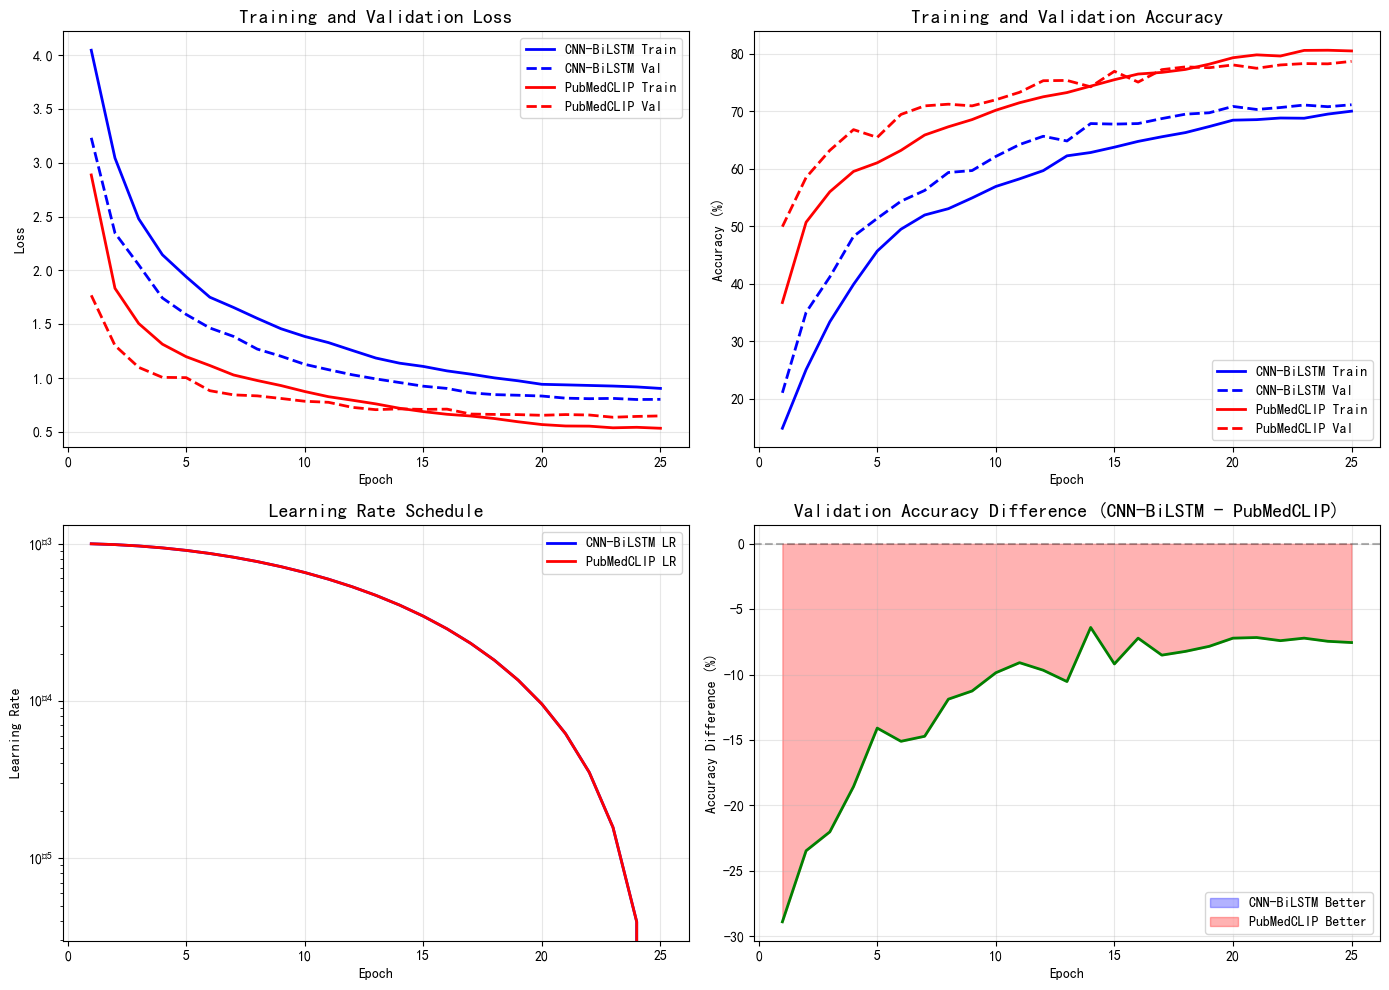

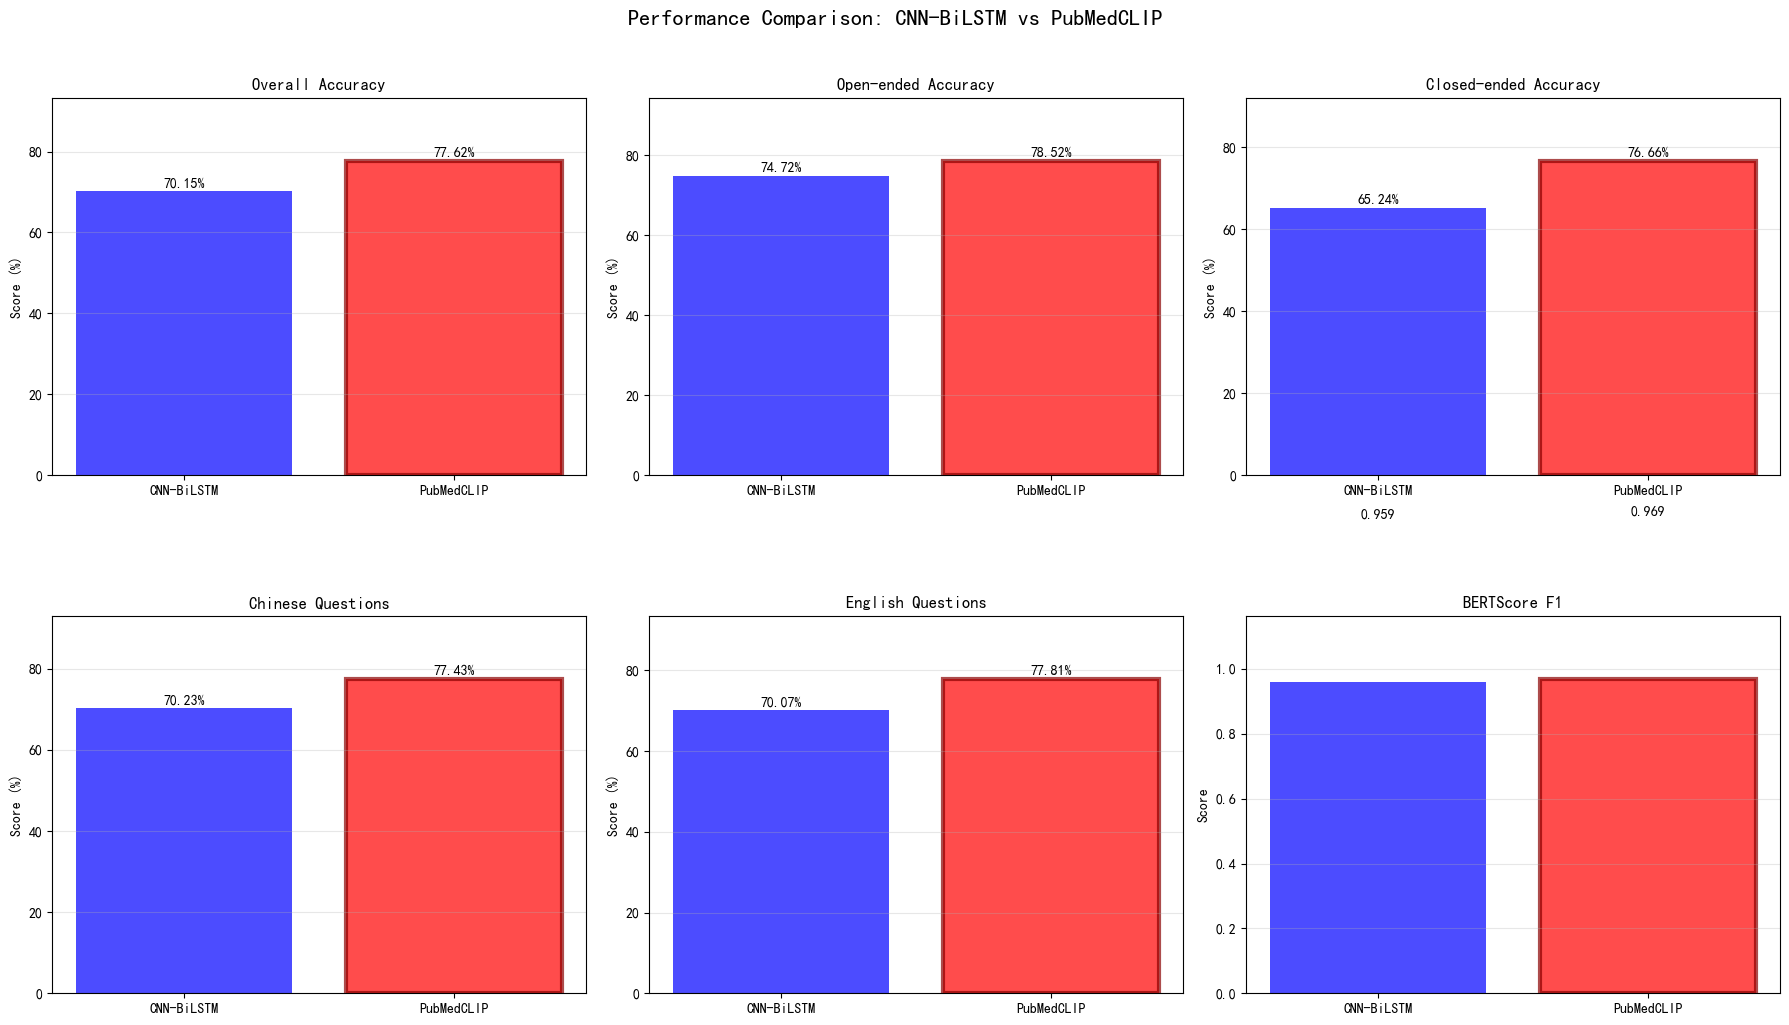

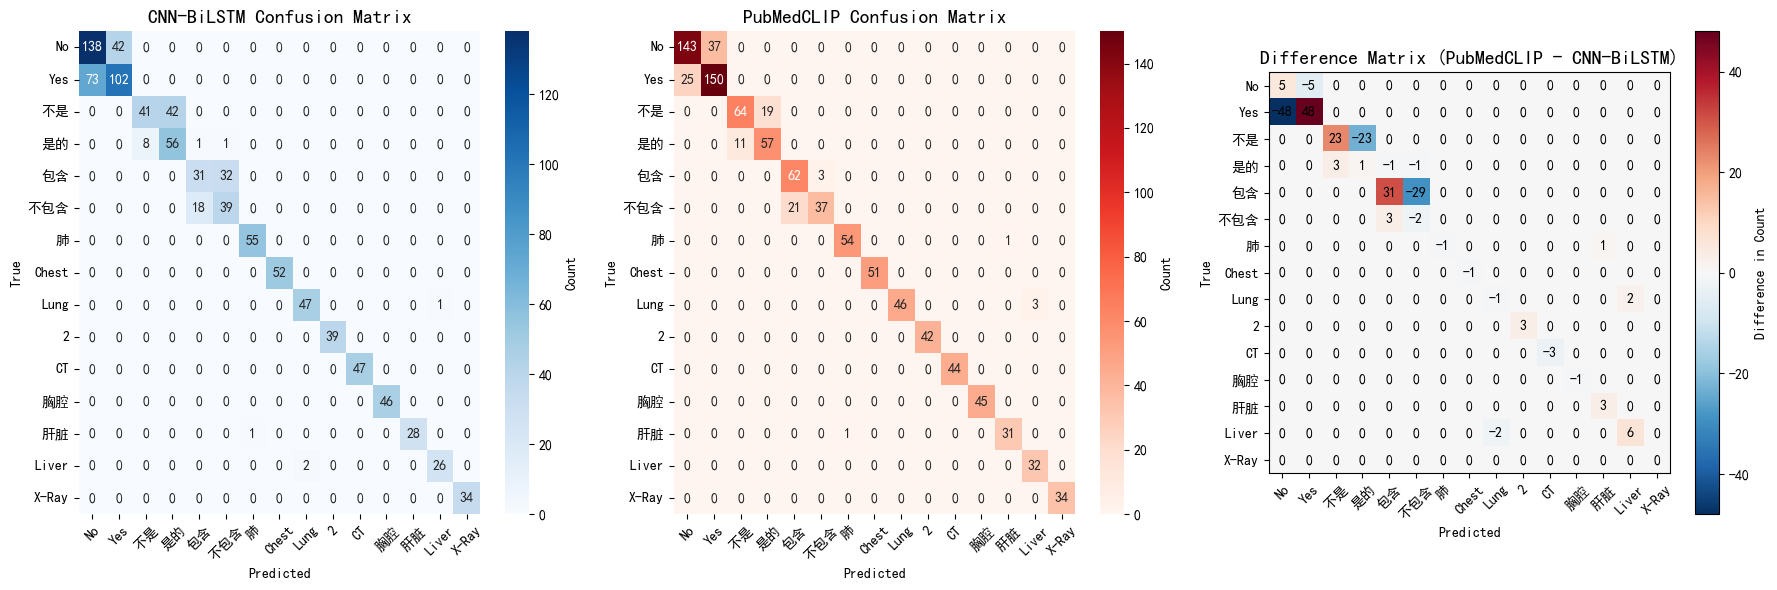

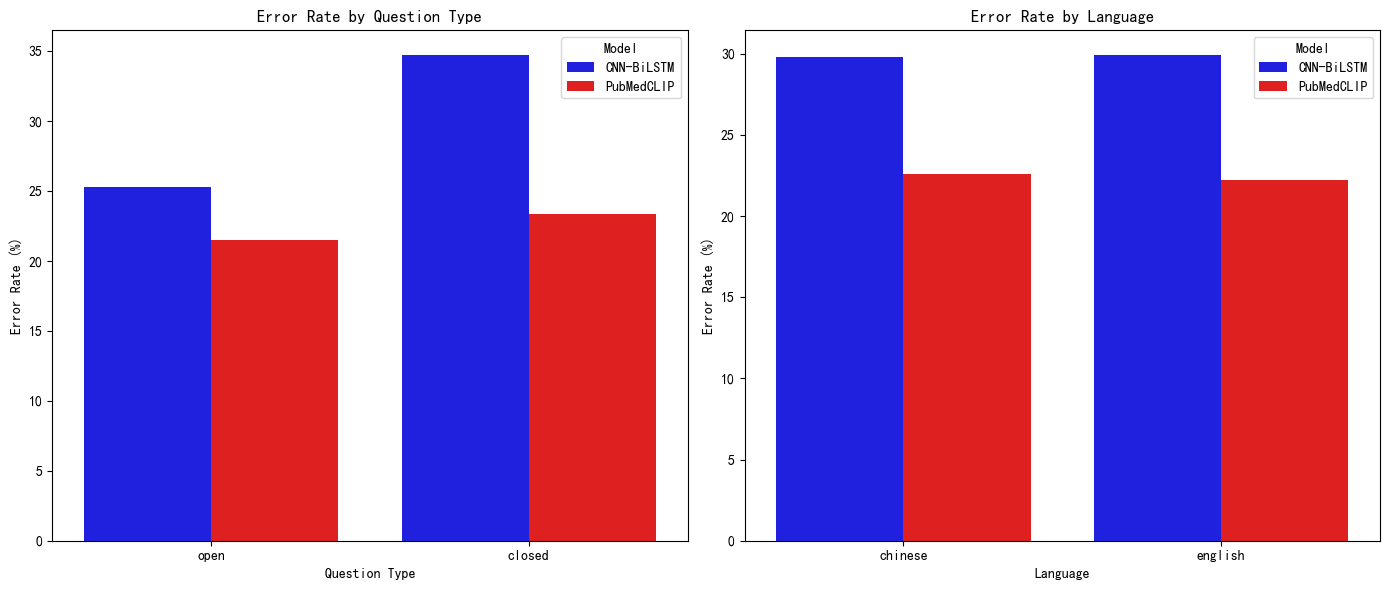

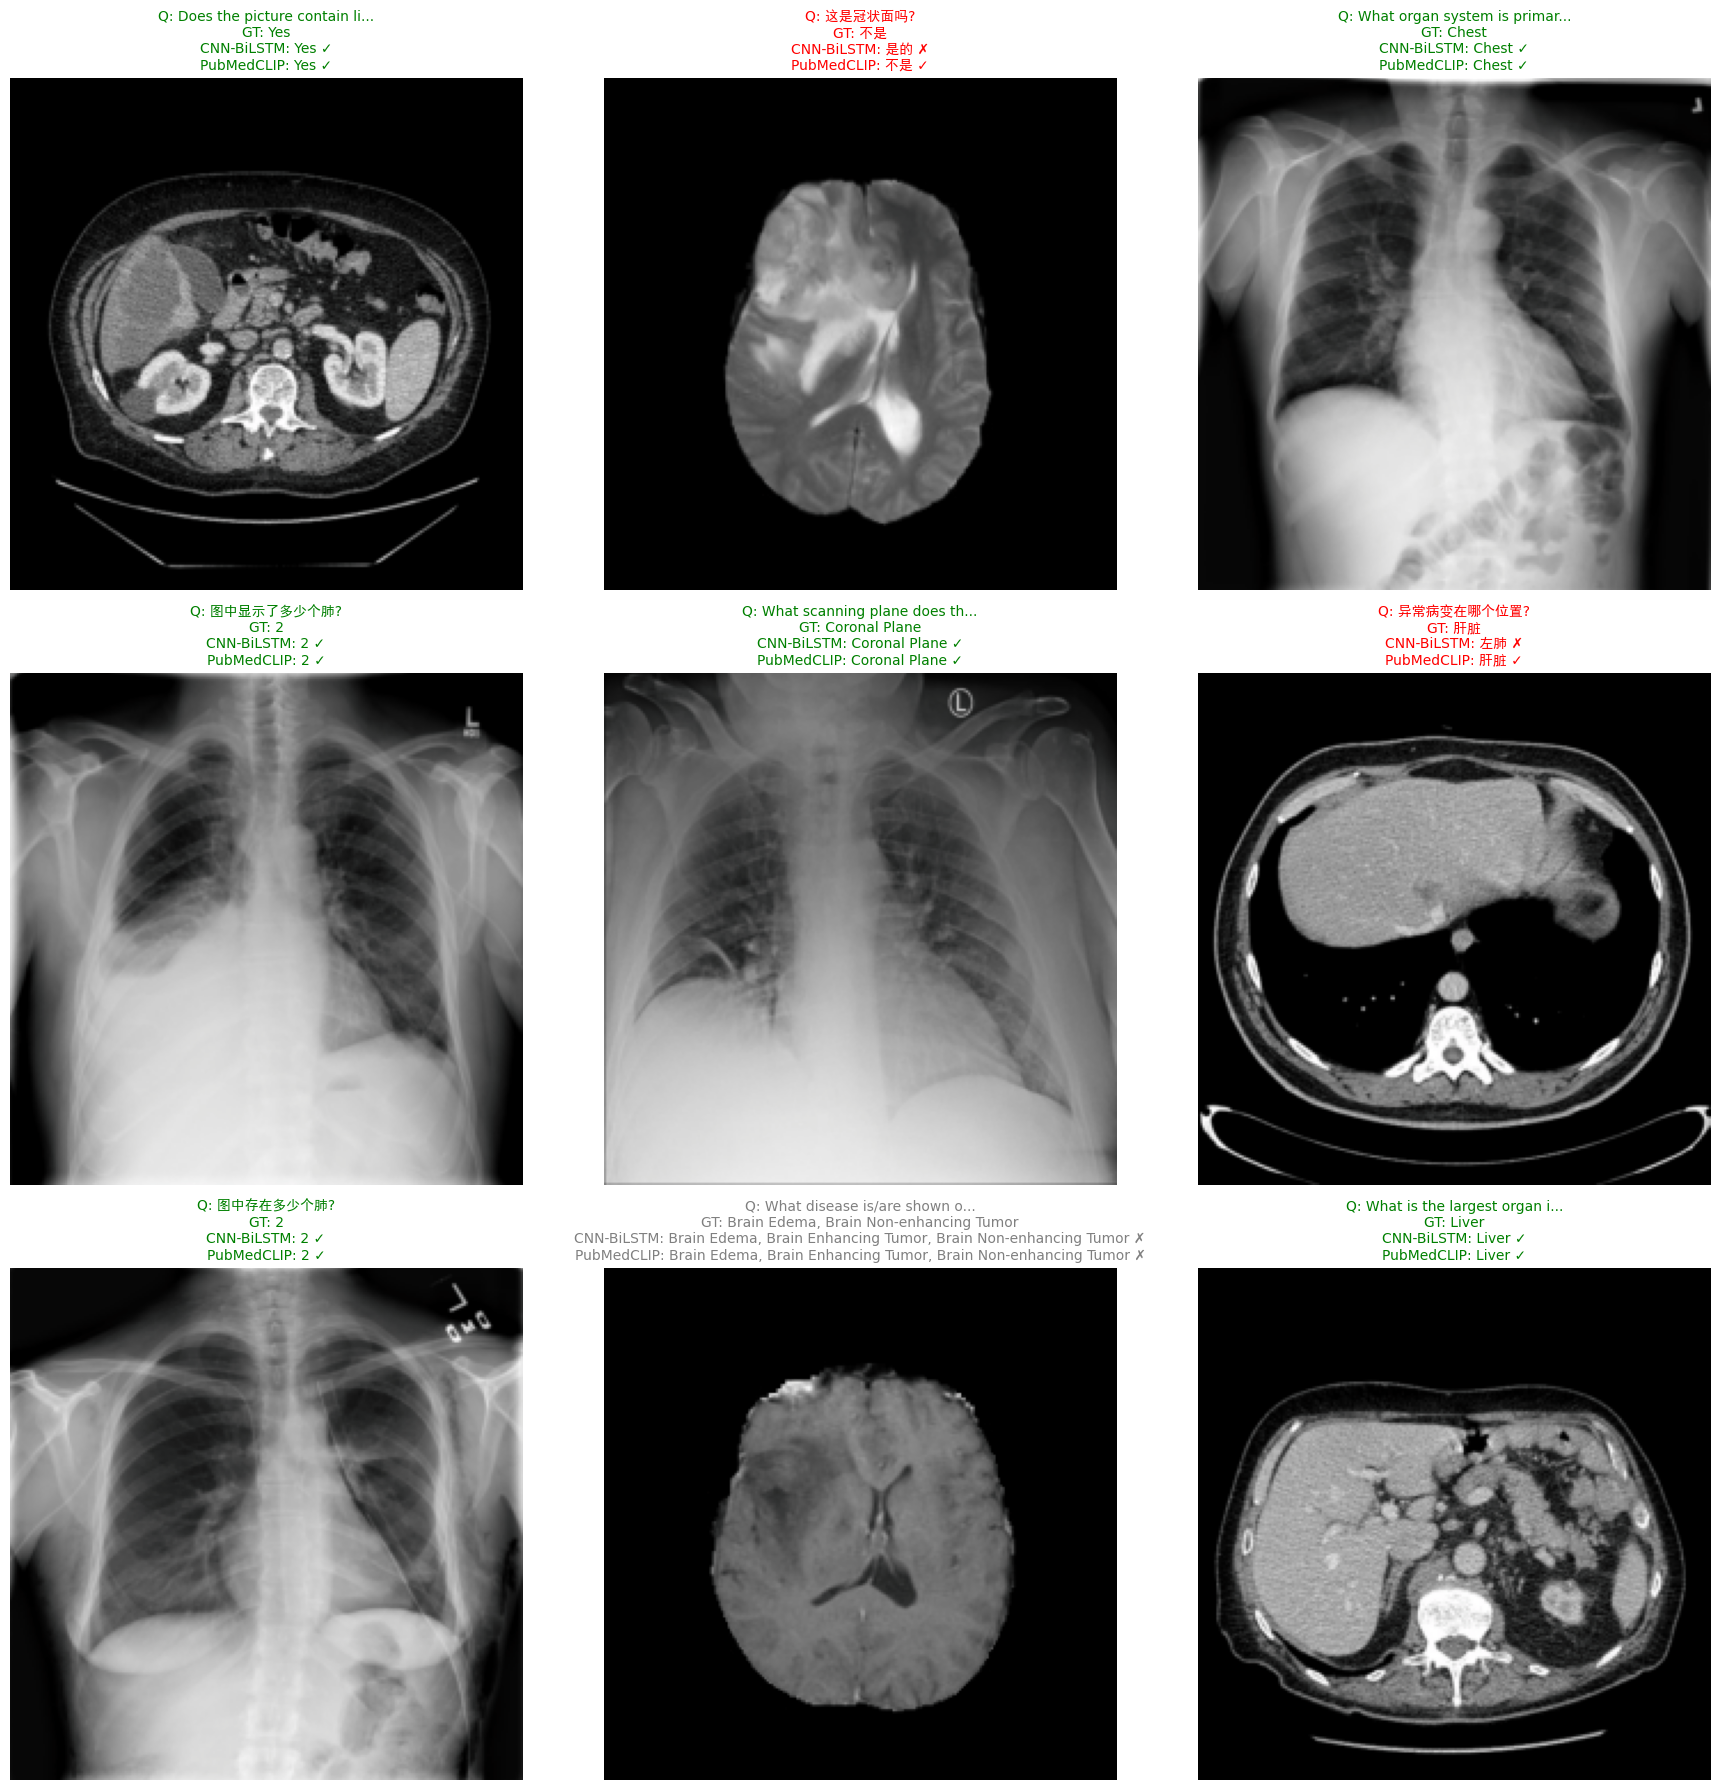

In [46]:
viz = Visualization()

# Training History
viz.plot_training_history(cnn_bilstm_history,
                          clip_history,
                          save_path='/content/drive/MyDrive/AML AA/training_history.png')

# Performance Comparison
cnn_bilstm_results_dict = {'overall_accuracy': cnn_bilstm_acc,
                         'analysis': cnn_bilstm_analysis,
                         'bertscore_results': cnn_bilstm_bertscore}

clip_results_dict = {'overall_accuracy': clip_acc,
                     'analysis': clip_analysis,
                     'bertscore_results': clip_bertscore}

viz.plot_performance_comparison(cnn_bilstm_results_dict,
                                clip_results_dict,
                                save_path='/content/drive/MyDrive/AML AA/performance_comparison.png')

# Confusion Matrices
viz.plot_confusion_matrices(cnn_bilstm_results,
                            clip_results,
                            id_to_answer,
                            top_n_answers=15,
                            save_path='/content/drive/MyDrive/AML AA/confusion_matrices.png')

# Error Analysis
viz.plot_error_analysis(cnn_bilstm_results,
                        clip_results,
                        save_path='/content/drive/MyDrive/AML AA/error_analysis.png')

# Sample Predictions
viz.visualize_sample_predictions(cnn_bilstm_model,
                                 clip_model,
                                 val_dataset,
                                 id_to_answer,
                                 num_samples=9,
                                 save_path='/content/drive/MyDrive/AML AA/sample_predictions.png')

In [47]:
comparison_df = pd.DataFrame({
    'Metric': ['Overall Accuracy', 'Open-ended Acc', 'Closed-ended Acc',
              'Chinese Acc', 'English Acc', 'BERTScore F1',
              'Trainable Parameters'],
    'CNN-BiLSTM': [
        f"{cnn_bilstm_acc:.2f}%",
        f"{cnn_bilstm_analysis.get('open_accuracy', 0):.2f}%",
        f"{cnn_bilstm_analysis.get('closed_accuracy', 0):.2f}%",
        f"{cnn_bilstm_analysis.get('chinese_accuracy', 0):.2f}%",
        f"{cnn_bilstm_analysis.get('english_accuracy', 0):.2f}%",
        f"{cnn_bilstm_bertscore.get('mean_f1', 0):.3f}" if cnn_bilstm_bertscore else "N/A",
        f"{cnn_params:,}",
        ],
    'PubMedCLIP': [
        f"{clip_acc:.2f}%",
        f"{clip_analysis.get('open_accuracy', 0):.2f}%",
        f"{clip_analysis.get('closed_accuracy', 0):.2f}%",
        f"{clip_analysis.get('chinese_accuracy', 0):.2f}%",
        f"{clip_analysis.get('english_accuracy', 0):.2f}%",
        f"{clip_bertscore.get('mean_f1', 0):.3f}" if clip_bertscore else "N/A",
        f"{clip_params:,}"
        ],
    'Difference': [
        f"{clip_acc - cnn_bilstm_acc:+.2f}%",
        f"{clip_analysis.get('open_accuracy', 0) - cnn_bilstm_analysis.get('open_accuracy', 0):+.2f}%",
        f"{clip_analysis.get('closed_accuracy', 0) - cnn_bilstm_analysis.get('closed_accuracy', 0):+.2f}%",
        f"{clip_analysis.get('chinese_accuracy', 0) - cnn_bilstm_analysis.get('chinese_accuracy', 0):+.2f}%",
        f"{clip_analysis.get('english_accuracy', 0) - cnn_bilstm_analysis.get('english_accuracy', 0):+.2f}%",
        f"{(clip_bertscore.get('mean_f1', 0) if clip_bertscore else 0) - (cnn_bilstm_bertscore.get('mean_f1', 0) if cnn_bilstm_bertscore else 0):+.3f}",
        f"{clip_params - cnn_params:,}"
        ]
    })

print("\n" + comparison_df.to_string(index=False))


              Metric CNN-BiLSTM PubMedCLIP  Difference
    Overall Accuracy     70.15%     77.62%      +7.47%
      Open-ended Acc     74.72%     78.52%      +3.80%
    Closed-ended Acc     65.24%     76.66%     +11.42%
         Chinese Acc     70.23%     77.43%      +7.20%
         English Acc     70.07%     77.81%      +7.74%
        BERTScore F1      0.959      0.969      +0.010
Trainable Parameters 27,488,550 16,661,734 -10,826,816


In [50]:
def enhanced_evaluation(model, dataloader, id_to_answer, device, model_name="Model"):
    """Comprehensive evaluation with detailed metrics."""
    model.eval()
    results = []

    with torch.no_grad():
        for batch in dataloader:
            actual_questions = batch.get('question', None)

            if actual_questions is None:
                # Try alternative key names
                if 'question_text' in batch:
                    actual_questions = batch['question_text']
                elif 'questions' in batch:
                    actual_questions = batch['questions']

            # Forward pass
            if "BioMedCLIP" in model_name or "clip" in model_name.lower():
                images = batch['pil_image']
                device = next(model.parameters()).device
                try:
                    logits = model(images, actual_questions if actual_questions else batch['question_text'])
                except Exception as e:
                    print(f"Warning in forward pass: {e}")
                    # Create dummy logits
                    logits = torch.randn(len(images), len(id_to_answer)).to(device)
            else:
                images = batch['pixel_values'].to(device)
                questions_tensor = batch['input_ids'].to(device)
                logits = model(images, questions_tensor)

            labels = batch['labels'].to(device)
            predictions = logits.argmax(dim=-1)

            # Collect results
            for i in range(len(predictions)):
                pred_idx = predictions[i].item()
                gt_idx = labels[i].item()

                pred_answer = id_to_answer.get(pred_idx, "UNKNOWN")
                gt_answer = id_to_answer.get(gt_idx, "UNKNOWN")

                # Handle different batch structures
                if actual_questions is not None:
                    question = actual_questions[i]
                else:
                    question = f"Question_{i}"

                results.append({
                    'question': question,
                    'predicted': pred_answer,
                    'ground_truth': gt_answer,
                    'correct': int(pred_answer == gt_answer),
                    'question_language': detect_language(question),
                    'question_type': classify_question_type(question),
                    'is_augmented': batch.get('is_augmented', [False] * len(predictions))[i]
                })
            pass

    df_results = pd.DataFrame(results)

    # === ADD DEBUG CODE HERE ===
    print(f"\n=== BERTScore for {model_name} ===")
    print(f"Total samples: {len(df_results)}")

    if 'question_type' in df_results.columns:
        question_type_counts = df_results['question_type'].value_counts()
        print(f"Question Type Distribution:")
        print(question_type_counts)

        # Calculate accuracy by question type
        for q_type in ['open', 'closed']:
            if q_type in df_results['question_type'].values:
                mask = df_results['question_type'] == q_type
                acc = 100 * df_results[mask]['correct'].mean()
                count = mask.sum()
                print(f"  {q_type}: {count} samples, Accuracy: {acc:.1f}%")

    # BERTScore for open-ended questions
    bertscore_results = {}
    if config.EVALUATE_BERTSCORE:
        open_mask = df_results['question_type'] == 'open'

        print(f"\nOpen-ended samples: {open_mask.sum()}")

        if open_mask.any():
            open_df = df_results[open_mask]

            # === DEBUG: Check what's being compared ===
            print("\nFirst 10 open-ended Q&A pairs:")
            for i in range(min(10, len(open_df))):
                pred = str(open_df.iloc[i]['predicted'])
                gt = str(open_df.iloc[i]['ground_truth'])
                correct = open_df.iloc[i]['correct']

                print(f"  Sample {i}:")
                print(f"    Pred: '{pred}'")
                print(f"    GT:   '{gt}'")
                print(f"    Correct: {bool(correct)}")
                print(f"    Exact match: {pred == gt}")
                print()

            predictions_list = open_df['predicted'].astype(str).tolist()
            references_list = open_df['ground_truth'].astype(str).tolist()

            # Calculate exact match rate for open-ended
            exact_matches = sum(1 for p, r in zip(predictions_list, references_list) if p == r)
            exact_match_rate = exact_matches / len(predictions_list)
            print(f"\nOpen-ended exact match rate: {exact_match_rate:.3f} ({exact_matches}/{len(predictions_list)})")

            # Now calculate BERTScore
            P, R, F1 = evaluate_bertscore_batched(predictions_list, references_list)

            # Store BERTScore for each sample
            open_df.loc[:, 'bertscore_f1'] = F1

            print(f"\nBERTScore Statistics:")
            print(f"  Mean F1: {F1.mean():.3f}")
            print(f"  Min F1: {F1.min():.3f}")
            print(f"  Max F1: {F1.max():.3f}")
            print(f"  Std F1: {F1.std():.3f}")

            # Show samples with low BERTScore
            low_f1_indices = np.where(F1 < 0.5)[0]
            if len(low_f1_indices) > 0:
                print(f"\nSamples with BERTScore F1 < 0.5:")
                for idx in low_f1_indices[:5]:  # Show first 5
                    print(f"  Sample {idx}: Pred='{predictions_list[idx]}', GT='{references_list[idx]}', F1={F1[idx]:.3f}")

            bertscore_results = {
                'mean_precision': P.mean(),
                'mean_recall': R.mean(),
                'mean_f1': F1.mean(),
                'std_f1': F1.std(),
                'num_samples': len(open_df),
                'exact_match_rate': exact_match_rate
            }

    if len(df_results) == 0:
        return df_results, 0, {}, {}

    # Calculate metrics
    overall_accuracy = 100 * df_results['correct'].mean()
    analysis = {}

    # By question type
    if 'question_type' in df_results.columns:
        for q_type in ['open', 'closed']:
            mask = df_results['question_type'] == q_type
            if mask.any():
                analysis[f'{q_type}_accuracy'] = 100 * df_results[mask]['correct'].mean()
                analysis[f'{q_type}_count'] = mask.sum()

    # By language
    if 'question_language' in df_results.columns:
        for lang in ['chinese', 'english']:
            mask = df_results['question_language'] == lang
            if mask.any():
                analysis[f'{lang}_accuracy'] = 100 * df_results[mask]['correct'].mean()
                analysis[f'{lang}_count'] = mask.sum()

    # BERTScore for open-ended questions
    bertscore_results = {}
    if config.EVALUATE_BERTSCORE:
        open_mask = df_results['question_type'] == 'open'
        if open_mask.any():
            open_df = df_results[open_mask]
            predictions_list = open_df['predicted'].astype(str).tolist()
            references_list = open_df['ground_truth'].astype(str).tolist()

            P, R, F1 = evaluate_bertscore_batched(predictions_list, references_list)
            open_df.loc[:, 'bertscore_f1'] = F1

            bertscore_results = {'mean_precision': P.mean(),
                                 'mean_recall': R.mean(),
                                 'mean_f1': F1.mean(),
                                 'std_f1': F1.std(),
                                 'num_samples': len(open_df)}

    return df_results, overall_accuracy, analysis, bertscore_results

In [51]:
# Get answer mappings
id_to_answer = preprocessed_data['train'].attrs['answer_mapping']['id_to_answer']

# Evaluate CNN-LSTM
print("\nEvaluating CNN-BiLSTM model...")
best_cnn_path = config.CNNMODEL_SAVE_PATH
best_cnn_epoch, best_cnn_val_acc = load_checkpoint(best_cnn_path, cnn_bilstm_model, None, device)
cnn_bilstm_results, cnn_bilstm_acc, cnn_bilstm_analysis, cnn_bilstm_bertscore = enhanced_evaluation(
    cnn_bilstm_model, test_loader, id_to_answer, device, model_name="CNN-BiLSTM"
)

# Evaluate PubMedCLIP
print("\nEvaluating PubMedCLIP model...")
best_clip_path = config.CLIPMODEL_SAVE_PATH
best_clip_epoch, best_clip_val_acc = load_checkpoint(best_clip_path, clip_model, None, device)
clip_results, clip_acc, clip_analysis, clip_bertscore = enhanced_evaluation(
    clip_model, test_clip_loader, id_to_answer, device, model_name="PubMedCLIP"
)

# Count trainable parameters
cnn_params = sum(p.numel() for p in cnn_bilstm_model.parameters() if p.requires_grad)
clip_params = sum(p.numel() for p in clip_model.parameters() if p.requires_grad)

print(f"\nCNN-BiLSTM Parameters: {cnn_params:,}")
print(f"PubMedCLIP Parameters: {clip_params:,}")


Evaluating CNN-BiLSTM model...
Loaded checkpoint: /content/drive/MyDrive/AML AA/cnn_bilstm.pth
Epoch: 24
Val Accuracy: 71.11%

=== BERTScore for CNN-BiLSTM ===
Total samples: 2087
Question Type Distribution:
question_type
open      1080
closed    1007
Name: count, dtype: int64
  open: 1080 samples, Accuracy: 74.7%
  closed: 1007 samples, Accuracy: 65.2%

Open-ended samples: 1080

First 10 open-ended Q&A pairs:
  Sample 0:
    Pred: 'CT'
    GT:   'CT'
    Correct: True
    Exact match: True

  Sample 1:
    Pred: 'Chest'
    GT:   'Chest'
    Correct: True
    Exact match: True

  Sample 2:
    Pred: 'Lung'
    GT:   'Lung'
    Correct: True
    Exact match: True

  Sample 3:
    Pred: 'Lung Cancer'
    GT:   'Lung Cancer'
    Correct: True
    Exact match: True

  Sample 4:
    Pred: 'Left Lung, Right'
    GT:   'Left Lung, Right'
    Correct: True
    Exact match: True

  Sample 5:
    Pred: 'Lung'
    GT:   'Lung'
    Correct: True
    Exact match: True

  Sample 6:
    Pred: 'CT'
